클래스 활성화의 히트맵 시각화하기
사전 훈련된 가중치로 Xception 네트워크 로드하기

In [18]:
from tensorflow import keras
import numpy as np
import matplotlib as plt

model = keras.applications.xception.Xception(weights="imagenet")

Xception 모델에 맞게 입력 이미지를 전처리하기

In [19]:
img_path = keras.utils.get_file(
    fname="dog1.jpg",
    origin="https://ggsc.s3.amazonaws.com/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner.jpg")


def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

212377/212377 [==============================] - 0s 2us/step


In [20]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 418ms/step
[('n02093428', 'American_Staffordshire_terrier', 0.48792174), ('n02093256', 'Staffordshire_bullterrier', 0.19775364), ('n02110806', 'basenji', 0.012968319)]


In [21]:
np.argmax(preds[0])

180

마지막 합성곱 출력을 반환하는 모델 만들기

In [22]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

마지막 합성곱 출력 위에 있는 분류기에 적용하기 위한 모델 만들기

In [23]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

최상위 예측 클래스의 그레이디언트 계산하기

In [24]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

그레이디언트를 평균하고 채널 중요도 가중치 적용하기

In [25]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

히트맵 후처리하기

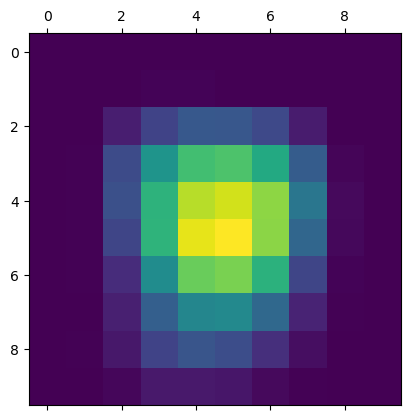

In [26]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

원본 이미지 위에 히트맵 그리기

In [27]:


img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = plt.colormaps.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "dog_cam.jpg"
superimposed_img.save(save_path)

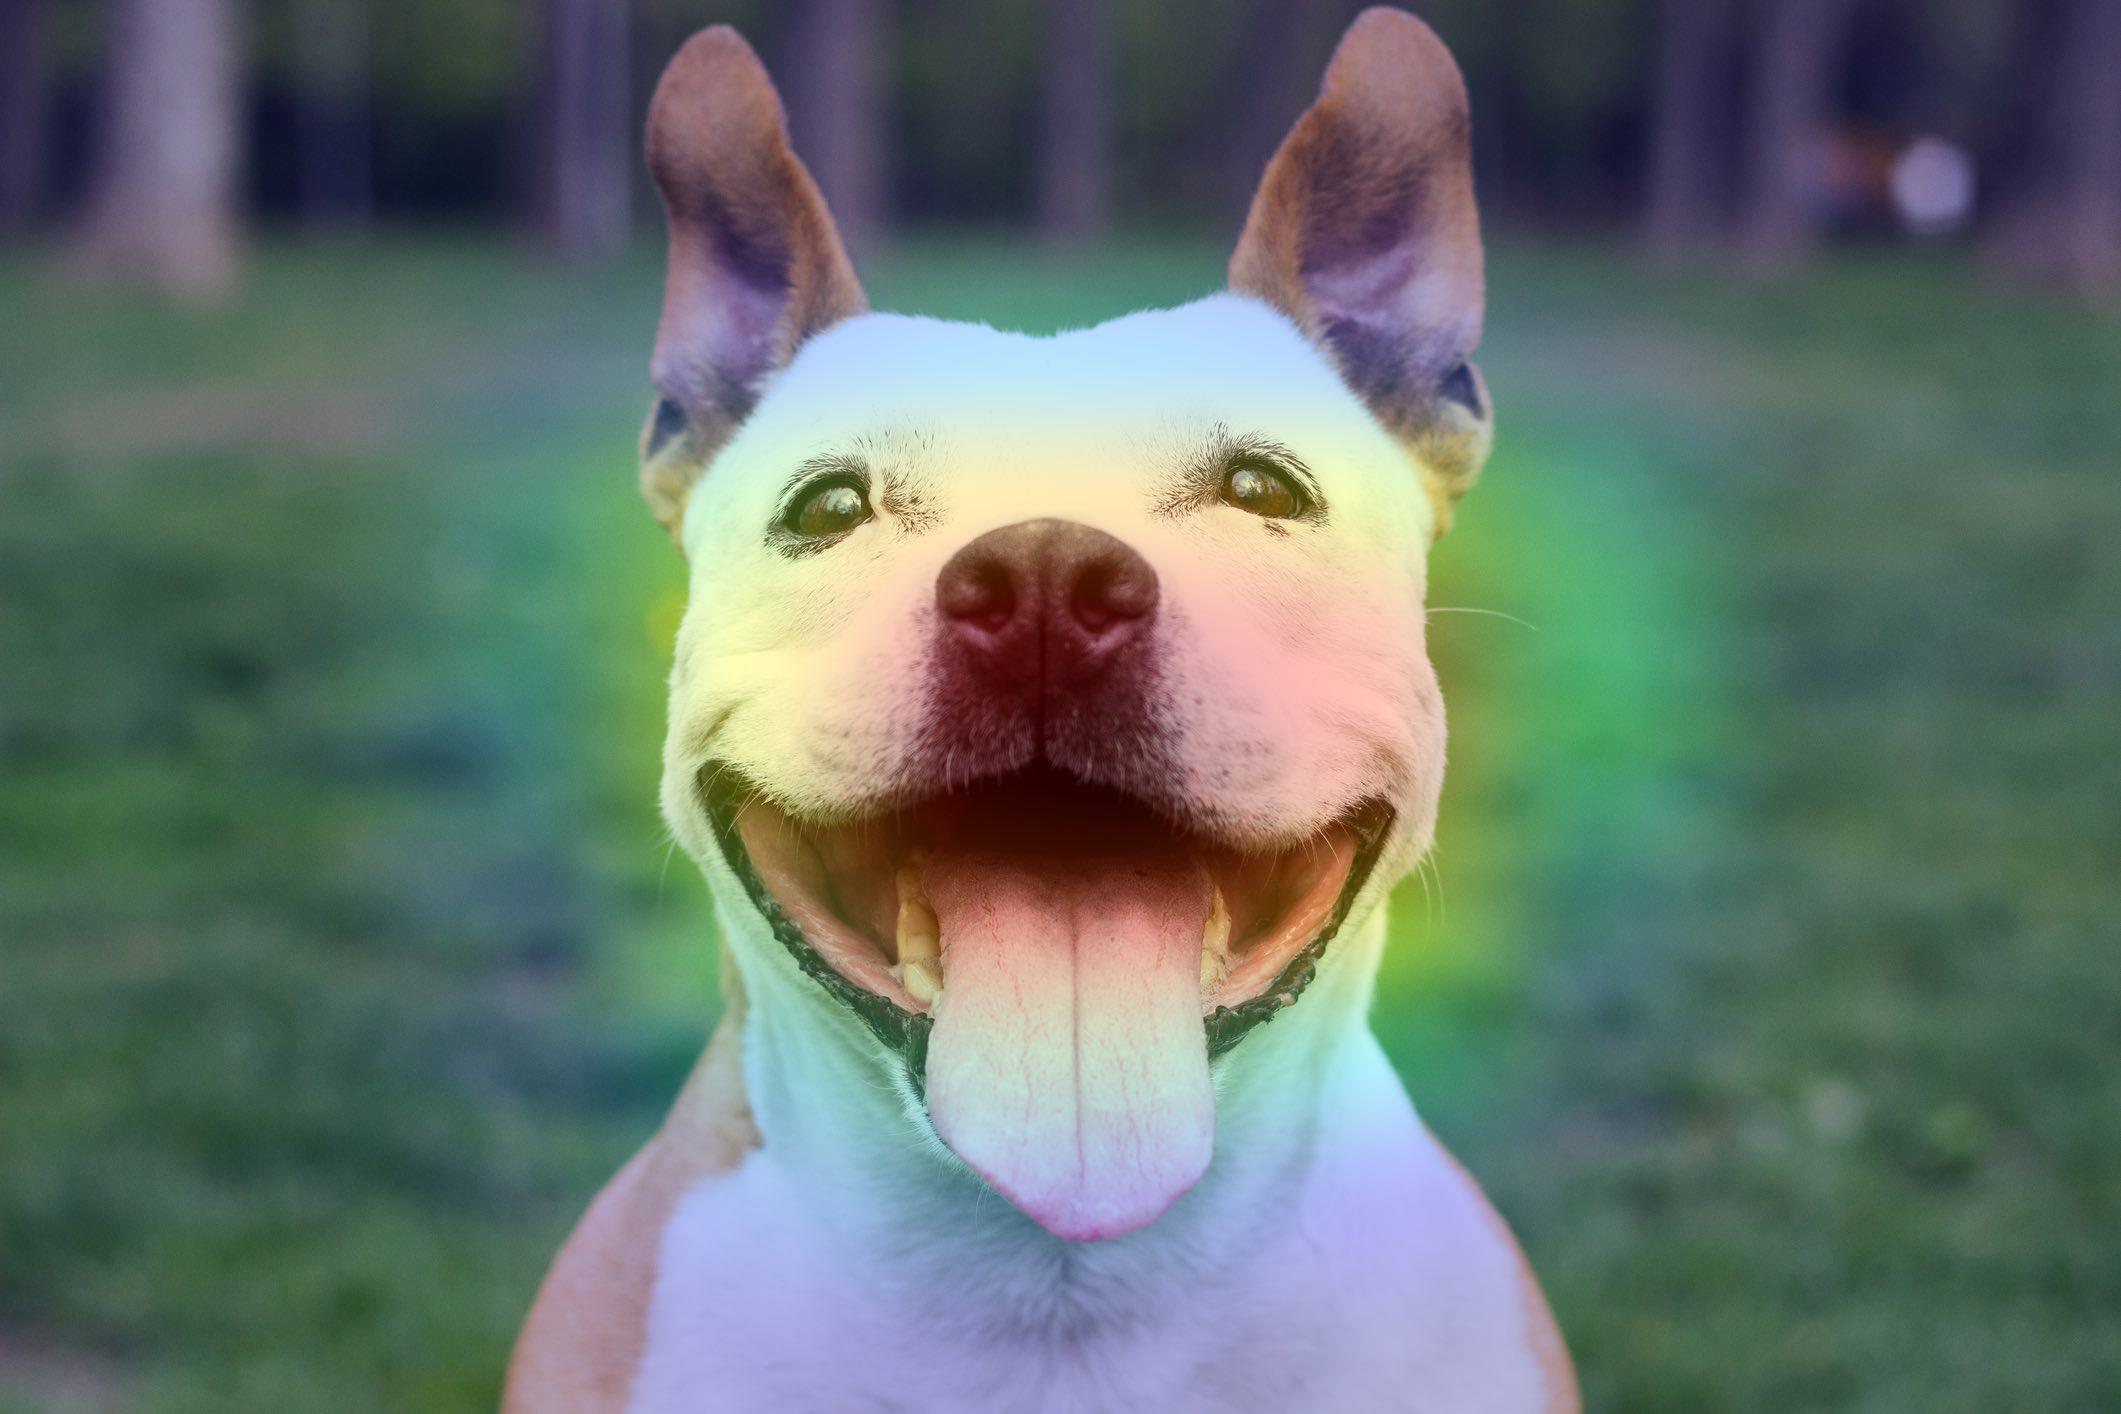

In [28]:
from IPython.display import Image

Image("dog_cam.jpg")